In [146]:
import numpy as np
def cross_covariance_lag1(mts_data):
    """
    Compute lag-1 cross-covariance block matrix for a single MTS object.
    Returns: (block_matrix, X_t, X_t+1)
    """
    X_t = mts_data[:-1, :]
    X_t_plus_1 = mts_data[1:, :]
    p = X_t.shape[1]

    Gamma0 = np.cov(X_t.T, bias=True)              # shape: (p, p)
    Gamma1 = np.cov(X_t.T, X_t_plus_1.T, bias=True)[:p, p:]  # shape: (p, p)

    Gamma1_T = Gamma1.T
    top = np.hstack((Gamma0, Gamma1))              # shape: (p, 2p)
    bottom = np.hstack((Gamma1_T, Gamma0))         # shape: (p, 2p)
    block_matrix = np.vstack((top, bottom))        # shape: (2p, 2p)

    return block_matrix, X_t, X_t_plus_1

In [147]:
import numpy as np
def combine_xt_xt1(X_t, X_t_plus_1):
    """
    Combine X_t and X_t+1 matrices along the column axis.

    Parameters:
        X_t (ndarray): (n-1) x p matrix
        X_t_plus_1 (ndarray): (n-1) x p matrix

    Returns:
        ndarray: Combined (n-1) x 2p matrix
    """
    combined_matrix = np.hstack((X_t, X_t_plus_1))
    return combined_matrix


In [148]:


def cross_covariance_lag2(mts_data):
    """
    Compute the block matrix using lag-0 and lag-2 cross-covariances.

    Parameters:
    mts_data: np.ndarray
        A (n x p) matrix where n is the number of time points and p is the number of variables.

    Returns:
    block_matrix: np.ndarray
        A (2p x 2p) matrix combining lag-0 and lag-2 covariances.
    X_t, X_t_plus_2: np.ndarray
        Lagged time series matrices.
    """
    n, p = mts_data.shape

    if n < 3:
        raise ValueError("The multivariate time series should have at least 3 time points.")

    # Lag-0 covariance
    Gamma_0 = np.cov(mts_data, rowvar=False, bias=True)

    # Lag-2 cross-covariance
    X_t = mts_data[:-2, :]        # From time t
    X_t_plus_2 = mts_data[2:, :]  # From time t+2

    # Full covariance and extract top-right block
    Gamma_2 = np.cov(X_t.T, X_t_plus_2.T, bias=True)[:p,p:]

    # Build block matrix
    block_matrix = np.block([
        [Gamma_0,     Gamma_2],
        [Gamma_2.T,   Gamma_0]
    ])

    return block_matrix, X_t, X_t_plus_2


In [149]:
def combine_xt_x_t1(X_t,X_t_plus_1):
    """
    Combine two lagged matrices X_t and X_{t+l} side by side.

    Parameters:
    X_t, X_t_plus_1: np.ndarray
        Each of shape (n-l x p)

    Returns:
    combined_matrix: np.ndarray
        A (n-l x 2p) matrix
    """
     # should be a matrix
    return np.hstack([X_t, X_t_plus_1])
   

In [150]:
def standardize_mts(mts_data):
    """
    Standardizes each multivariate time series (MTS) object in the list.
    Each MTS is standardized column-wise (zero mean and unit variance).
    """
    standardized_data = [
        (sample - np.mean(sample, axis=0)) / np.std(sample, axis=0)
        for sample in mts_data
    ]
    return standardized_data


In [151]:
def compute_weighted_cross_cov(matrixU, m, cross_cov_lag0_lag1,cross_cov_lag0_lag2):
    n,k = matrixU.shape
    # initialize lists to store weighted cross-covariance matrices for each cluster
    
    weighted_cross_cov_lag0_lag1 = []
    weighted_cross_cov_lag0_lag2 = []
    for cluster in range(k):
        weights = matrixU[:,cluster] ** m 
        total_weight = np.sum(weights)
        if total_weight == 0:
            raise ValueError(f'Total weight for cluster {cluster} is zero. Check matrixU or fuzziness paramter m. ')
        weighted_cov_lag1 = sum(w * cov for w, cov in zip(weights,cross_cov_lag0_lag1))/total_weight
        weighted_cross_cov_lag0_lag1.append(weighted_cov_lag1)
        weighted_cov_lag2 = sum(w * cov for w,cov in zip(weights,cross_cov_lag0_lag2))/total_weight
        weighted_cross_cov_lag0_lag2.append(weighted_cov_lag2)
    return {
        'weighted_cross_cov_lag0_lag1':weighted_cross_cov_lag0_lag1,
        'weighted_cross_cov_lag0_lag2':weighted_cross_cov_lag0_lag2
    }

In [152]:
import numpy as np

def compute_S(reconstruction_error, projection_axes, n, k):
    """
    Compute the S value to help select fuzziness parameter m.
    Lower S is preferred. S = total reconstruction error / (n × min inter-cluster subspace distance).

    Parameters:
    - reconstruction_error: total reconstruction error (scalar)
    - projection_axes: list of dicts, each with 'lag01' and 'lag02' projection matrices
    - n: number of MTS objects
    - k: number of clusters (original, but real number of clusters = len(projection_axes))

    Returns:
    - S: scalar score for evaluating cluster separation vs reconstruction
    """

    # Build projection matrices list
    P_list = []
    for axes in projection_axes:
        if axes is None:
            continue
        C1 = axes['lag01']
        C2 = axes['lag02']
        P1 = C1 @ C1.T
        P2 = C2 @ C2.T
        P_list.append({'P_lag1': P1, 'P_lag2': P2})

    k_actual = len(P_list)

    # Safety check
    if k_actual < 2:
        return np.inf  # Cannot compute pairwise distance with < 2 clusters

    # Define subspace distance between two clusters
    def subspace_dist(Pa, Pb):
        d1 = np.linalg.norm(Pa['P_lag1'] - Pb['P_lag1'], ord='fro')
        d2 = np.linalg.norm(Pa['P_lag2'] - Pb['P_lag2'], ord='fro')
        return d1 + d2

    # Compute min pairwise subspace distance
    min_dist = np.inf
    for c in range(k_actual):
        for m in range(c + 1, k_actual):
            dist_val = subspace_dist(P_list[c], P_list[m])
            if dist_val < min_dist:
                min_dist = dist_val

    # Avoid division by zero
    if min_dist == 0:
        return np.inf

    # Compute final S value
    S = reconstruction_error / (n * min_dist)
    return S

In [153]:
def fcpca(ts,k,m=1.5,startU= None,conver = 1e-3,maxit = 1000,verbose = True,replicates = 1):
    ts = standardize_mts(ts)
    n = len(ts)
    p = ts[0].shape[1]
    results = [cross_covariance_lag1(x) for x in ts]
    results2 = [cross_covariance_lag2(x) for x in ts]
    sigma = [res[0] for res in results]
    sigma2 = [res[0] for res in results2]
    tsxt = [res[1] for res in results]
    tsxt1 = [res[2] for res in results]
    combined_list = [combine_xt_xt1(x, y) for x, y in zip(tsxt, tsxt1)]

    tsxt2 = [res[1] for res in results2]
    tsxt12 = [res[2] for res in results2]
    combined_list2 = [combine_xt_xt1(x, y) for x, y in zip(tsxt2, tsxt12)]
    best_result = None
    best_error = np.inf
    
    for replicate in range(replicates):
        if verbose:
            print('f\n Replicate {replicate +1}:')
        if startU is None:
            U = np.random.rand(n,k)
            U /= U.sum(axis = 1, keepdims = True)
        else:
            U = startU.copy()
        
        weighted_covariances = compute_weighted_cross_cov(U,m,sigma,sigma2)
        svd1 = np.linalg.svd(weighted_covariances['weighted_cross_cov_lag0_lag1'][0])
        n_components_lag01 = np.argmax(np.cumsum(svd1[1]) / np.sum(svd1[1]) >= 0.95) + 1
        svd2 = np.linalg.svd(weighted_covariances['weighted_cross_cov_lag0_lag2'][0])
        n_components_lag02 = np.argmax(np.cumsum(svd2[1]) / np.sum(svd2[1]) >= 0.95) + 1
        
        iteration = 0
        diff = np.inf
        prev_error = np.inf
        current_error = np.inf 
        while iteration < maxit and (abs(prev_error - current_error) > conver or diff > conver):
            iteration += 1
            weighted_covariances = compute_weighted_cross_cov(U,m,sigma,sigma2)
            projection_axes = []
            for c in range(k):                
                u1 = np.linalg.svd(weighted_covariances['weighted_cross_cov_lag0_lag1'][c])[0][:, :n_components_lag01]
                u2 = np.linalg.svd(weighted_covariances['weighted_cross_cov_lag0_lag2'][c])[0][:, :n_components_lag02]
                projection_axes.append({'lag01': u1, 'lag02': u2})
                
            total_reconstruction_error = np.zeros((n,k))
            for i in range(n):
                  for c in range(k):
                        recon1 = combined_list[i] @ projection_axes[c]['lag01'] @ projection_axes[c]['lag01'].T
                        error1 = np.linalg.norm(combined_list[i] - recon1, 'fro') ** 2
                        recon2 = combined_list2[i] @ projection_axes[c]['lag02'] @ projection_axes[c]['lag02'].T
                        error2 = np.linalg.norm(combined_list2[i] - recon2, 'fro') ** 2
                        total_reconstruction_error[i, c] = error1 + error2
            U_new = np.zeros_like(U)
            for i in range(n):
                for c in range(k):
                    denom = total_reconstruction_error[i, :] + 1e-10
                    U_new[i, c] = 1 / np.sum((total_reconstruction_error[i, c] / denom) ** (1 / (m - 1)))

            diff = np.max(np.abs(U - U_new))
            prev_error = current_error
            U = U_new
            current_error = np.sum((U ** m) * total_reconstruction_error)

            if verbose:
                print(f"Iteration {iteration}: Reconstruction Error = {current_error:.6f}, Max Change in U = {diff:.6f}")

        if current_error < best_error:
            best_error = current_error
            best_result = {
                'membership_matrix': U,
                'projection_axes': projection_axes,
                'iterations': iteration,
                'converged': iteration < maxit,
                'reconstruction_error': current_error,
                'reconstruction_error_matrix': total_reconstruction_error,
                'hard_cluster': np.argmax(U, axis=1),
                'weighted_covariances': weighted_covariances,
                'S': compute_S(current_error, projection_axes, n, k)
            }

    return best_result
                        

In [154]:
import scipy.io

# Load MATLAB .mat file
mat_data = scipy.io.loadmat("/Users/maz0b/Desktop/FCPCA/real data/dataset.mat")

# Extract EEG samples (shape: [2022, 30, 384])
eeg_raw = mat_data['EEGsample']  # shape: (2022, 30, 384)
eeg_raw = eeg_raw.transpose(0, 2, 1)  # shape now (2022, 384, 30)

# Convert to list of 384x30 matrices 
EEGsample = [eeg_raw[i] for i in range(eeg_raw.shape[0])]

# Labels
substate = mat_data['substate'].flatten()
subindex = mat_data['subindex'].flatten()


In [155]:
subject_id = 11
idx = (subindex == subject_id)
EEGsample_subject = [EEGsample[i] for i in range(len(EEGsample)) if idx[i]]
label_subject = substate[idx]

In [156]:
# clustering using our FCPCA method 
a = fcpca(ts=EEGsample_subject, k=2, m=1.1)

f
 Replicate {replicate +1}:
Iteration 1: Reconstruction Error = 466792.267803, Max Change in U = 0.511775
Iteration 2: Reconstruction Error = 466536.997965, Max Change in U = 0.054012
Iteration 3: Reconstruction Error = 466506.816131, Max Change in U = 0.042911
Iteration 4: Reconstruction Error = 466436.705883, Max Change in U = 0.060120
Iteration 5: Reconstruction Error = 466142.187779, Max Change in U = 0.124559
Iteration 6: Reconstruction Error = 465614.466076, Max Change in U = 0.160667
Iteration 7: Reconstruction Error = 464030.314404, Max Change in U = 0.243462
Iteration 8: Reconstruction Error = 463324.424711, Max Change in U = 0.078134
Iteration 9: Reconstruction Error = 463113.826662, Max Change in U = 0.061618
Iteration 10: Reconstruction Error = 462627.682644, Max Change in U = 0.169720
Iteration 11: Reconstruction Error = 462299.198711, Max Change in U = 0.095981
Iteration 12: Reconstruction Error = 462040.654604, Max Change in U = 0.085688
Iteration 13: Reconstruction Err

In [157]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import confusion_matrix

def rand_index(true_labels, pred_labels):
    """
    Compute the unadjusted Rand Index (RI)
    """
    from itertools import combinations

    n = len(true_labels)
    agree = 0
    total = 0

    for (i, j) in combinations(range(n), 2):
        same_true = true_labels[i] == true_labels[j]
        same_pred = pred_labels[i] == pred_labels[j]
        agree += (same_true == same_pred)
        total += 1

    return agree / total

# Input labels
true = label_subject
predicted = a['hard_cluster']

# Rand Index
ri = rand_index(true, predicted)

# Adjusted Rand Index
ari = adjusted_rand_score(true, predicted)

# Normalized Mutual Information
nmi = normalized_mutual_info_score(true, predicted)

# Display
print(f"Rand Index (RI): {ri:.4f}")
print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")


Rand Index (RI): 0.8755
Adjusted Rand Index (ARI): 0.7510
Normalized Mutual Information (NMI): 0.7093


Fontconfig warning: ignoring UTF-8: not a valid region tag
Matplotlib is building the font cache; this may take a moment.


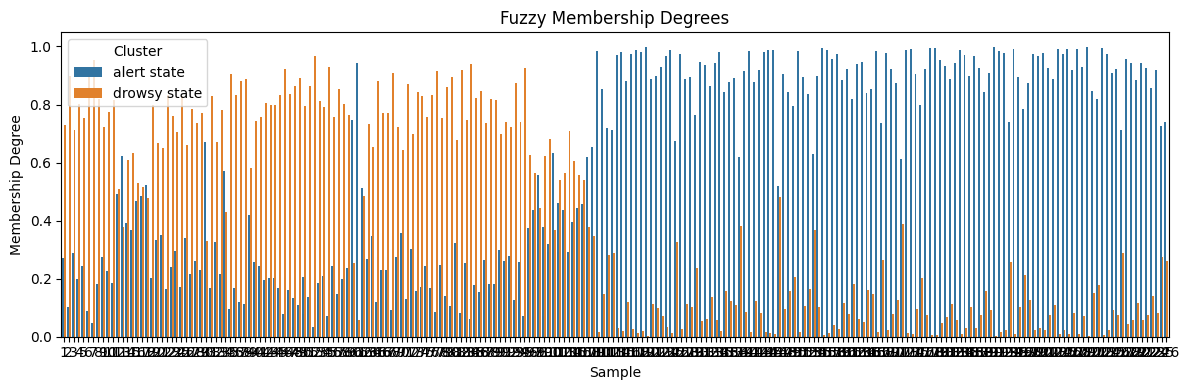

In [158]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

U = pd.DataFrame(a['membership_matrix'])
U['sample'] = range(1, len(U)+1)
U_long = pd.melt(U, id_vars='sample', var_name='cluster', value_name='membership')
U_long['cluster'] = U_long['cluster'].map({0: 'alert state', 1: 'drowsy state'})

plt.figure(figsize=(12, 4))
sns.barplot(data=U_long, x='sample', y='membership', hue='cluster')
plt.xlabel("Sample")
plt.ylabel("Membership Degree")
plt.legend(title="Cluster")
plt.title("Fuzzy Membership Degrees")
plt.tight_layout()
plt.show()

In [159]:
# Compare CVI vs RI over different m
m_values = np.round(np.arange(1.1, 2.3, 0.1), 2)
CVI_vec = []
RI_vec = []


for m in m_values:
    result = fcpca(ts=EEGsample_subject, k=2, m=m)
    CVI_vec.append(result['S'])
    RI_vec.append(rand_index(label_subject, result['hard_cluster']))

df = pd.DataFrame({'m': m_values, 'CVI': CVI_vec, 'RI': RI_vec})
df['logCVI'] = np.log(df['CVI'])
df['norm_logCVI'] = (df['logCVI'] - df['logCVI'].min()) / (df['logCVI'].max() - df['logCVI'].min())
df['norm_RI'] = (df['RI'] - df['RI'].min()) / (df['RI'].max() - df['RI'].min())

f
 Replicate {replicate +1}:
Iteration 1: Reconstruction Error = 466753.638104, Max Change in U = 0.493165
Iteration 2: Reconstruction Error = 466324.253160, Max Change in U = 0.113095
Iteration 3: Reconstruction Error = 465576.221692, Max Change in U = 0.162359
Iteration 4: Reconstruction Error = 464124.956888, Max Change in U = 0.214636
Iteration 5: Reconstruction Error = 463464.395783, Max Change in U = 0.144397
Iteration 6: Reconstruction Error = 462909.145864, Max Change in U = 0.128776
Iteration 7: Reconstruction Error = 462712.935300, Max Change in U = 0.056985
Iteration 8: Reconstruction Error = 462666.909992, Max Change in U = 0.045121
Iteration 9: Reconstruction Error = 462648.434092, Max Change in U = 0.035412
Iteration 10: Reconstruction Error = 462632.246186, Max Change in U = 0.029570
Iteration 11: Reconstruction Error = 462608.465729, Max Change in U = 0.035481
Iteration 12: Reconstruction Error = 462563.003853, Max Change in U = 0.053442
Iteration 13: Reconstruction Err

In [162]:
df

,m,CVI,RI,logCVI,norm_logCVI,norm_RI
0,1.1,448.769840,0.875516,6.106510,0.000000,1.000000
1,1.2,658.062857,0.644130,6.489300,0.052553,0.194110
2,1.3,16526.545316,0.674336,9.712723,0.495097,0.299315
3,1.4,198418.429141,0.674336,12.198133,0.836318,0.299315
4,1.5,327811.142421,0.674336,12.700193,0.905246,0.299315
5,1.6,525808.029783,0.674336,13.172691,0.970115,0.299315
6,1.7,565948.770197,0.674336,13.246259,0.980215,0.299315
7,1.8,653676.830926,0.679646,13.390368,1.000000,0.317808
8,1.9,152748.274154,0.588397,11.936547,0.800405,0.000000
9,2.0,594161.915527,0.674336,13.294907,0.986894,0.299315


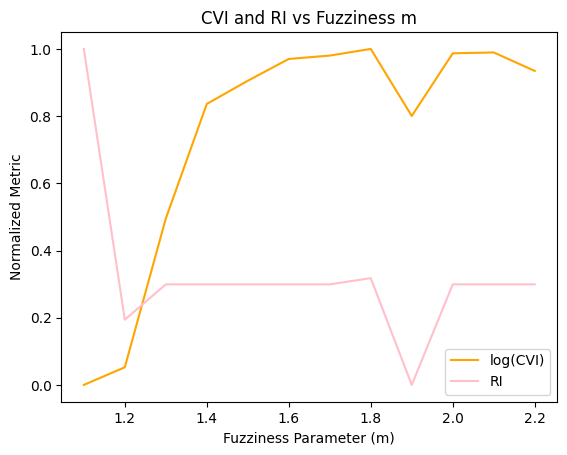

In [163]:
sns.lineplot(data=df, x='m', y='norm_logCVI', label='log(CVI)', color='orange')
sns.lineplot(data=df, x='m', y='norm_RI', label='RI', color='pink')
plt.title("CVI and RI vs Fuzziness m")
plt.xlabel("Fuzziness Parameter (m)")
plt.ylabel("Normalized Metric")
plt.show()
# this shows the RI value as reported in our paper 